# NATF017 Project

Runqing Yang

Synchrotron radiation research, Physics department, Lund University

## README


### Abstract

This Jupyter Notebook is the project work for Course <u> Reproducible and Interactive Data Analysis and Modelling using Jupyter Notebooks (NATF017)</u>. 

This project focuses on phase reconstruction of coherent diffraction imaging (CDI) and visualization of reconstructed images from ptychography using Ptypy. In the first part, Error reduction (ER) and Hybrid-Input-Output (HIO) algorithms are introduced, python code included for the reconstruction process. With the interact function, the different result is visualization casued by adjusting the parameters. The second part introduces ptychography, and the ptypy package used for reconstruction. This project does not include the reconstruction process, only showing the impact of different binning numbers and algorithms on the reconstruction results.


### Instructions

Here are the essential packages that need to be installed for this project, or download and install the **environment.yaml** file. The reason for choosing the packages will be introduced in the comments of the code. 

- h5py
- numpy
- matplotlib
- ipywidgets
- silx.io

For running this Jupyter notebook, need to download the dataset which are contained in **ReconData** folder. 

## Phase retrieval

One of the crucial problems needs to be faced in X-ray imaging is the loss of phase in the diffraction intensity, which is known as crystallographic phase problem [1]. In Miao’s paper [2], they explained a feasible method to over come this problem. They demonstrated that through oversampling the diffraction pattern and using iterative algorithms can reconstruct the image. 

This project focuses on introducing Hybrid-Input-Output algorithm and Error reduction algorithm [3] based on Jupyter notebook. To retrive the phase from prodeted data, usually the Fourier amplitude modulus in the detector $F(x)$, initial object guess $g(x)$ and an object constraint domain are required. The flowchart below illustrates the basic process of phase retrieval algorithms.

<img style="flot: left;" src="img/CDI.jpg" width=600 height=300>


### Error reduction
The Error reduction algorithm developed from the Gerchberg–Saxton algorithm [4]. In each ER iteration, it takes four steps to process. Following is the example of the $k_{th}$ iteration steps.
Step 1. Calculating the Furious transform of the  $k_{th}$ object guess $g_k(x)$ to get $G_k(u)$.
$$
G_{k} (u)=\left | G(u) \right |e^{i\phi _{k}(u) } =\mathcal{F} (g_{k} (x))
$$
Step 2. Updating the real part of $G_k(u)$ with the real part of $F(x)$.
$$
G^{\prime} _{k}(u)=\left | F(u) \right |e^{i\phi _{k}(u) } 
$$
Step 3. Calculating inverse  Furious transform of updated $G^{\prime} _{k}(u)$ to get $g^{\prime}_{k} (x)$.
$$
g^{\prime}_{k} (x)=\left | g^{\prime}_{k} (x) \right |e^{i\theta ^{\prime _{k}}(x)} =\mathcal{F}^{-1} (G^{\prime}_{k}(u)) 
$$
Step 4. Preparing $g_{k+1}(x)$ for next iteration. The region $\gamma$ contains all the points violate the constraints. Need to note that all the $f(x)$ should be real and non-negative, and also within the given object constraint domain. 
$$
g_{k+1}(x)=
    \begin{cases}
      g^{\prime}_{k}(x), & \text{if}\ x\notin \gamma \\
      0, & \text{if}\ x\in \gamma
    \end{cases}
$$

### Hybrid-Input-Output algorithm
As for Hybrid-Input-Output algorithm [5], the first three steps are the same with the Error reduction algorithm explained above. At the final step, instead of forcing $g_{k+1}(x)$ to zero if $g^{\prime}_{k}(x)$ violates the constraints, it makes $g_{k+1}(x)=g_{k}(x)-\beta g^{\prime}_{k}(x)$ which contains feedback information from previous iteration. Here $\beta$ is a feedback parameter which can take a value between 0 and 1.
$$
g_{k+1}(x)=
    \begin{cases}
      g^{\prime}_{k}(x), & \text{if}\ x\notin \gamma \\
      g_{k}(x)-\beta g^{\prime}_{k}(x), & \text{if}\ x\in \gamma
    \end{cases}
$$


### Coding
This exercise combines the Hybrid-Input-Output algorithm and Error reduction algorithm together. Each iteration contains 45 times of HIO iterations and another 5 times of ER iteration. The coding is provided below.
The reconstructed image is shown in an interactive way, by adjusting the slides above the image can see how the reconstruction result is affected by the number of iterations and feedback parameter $\beta$.

In [1]:
# import library
import h5py   # import and read the data stored in .h5 file
import numpy as np # perform numerical operations
import matplotlib.pyplot as plt # plot images
from ipywidgets import interact # interative image
import ipywidgets as widgets

# import data
hf = h5py.File('ReconData/CDI_exercise.h5','r')
FourierAmplitudeConstraint = np.array(hf.get('/data/FourierAmplitudeConstraint')[:]).T
RealSpaceSupport = np.array(hf.get('/data/RealSpaceSupport')[:]).T
InitialGuesReal = np.array(hf.get('/data/InitialGuesReal')[:]).T
InitialGuessImaginary = np.array(hf.get('/data/InitialGuessImaginary')[:]).T

# parameter setting
i_HIO = 45
i_ER = 5

def plot_CDI_recon(iteration=1,beta = 0.7):

    def CDI_recon(FourierAmplitudeConstraint,RealSpaceSupport,InitialGuesReal,InitialGuessImaginary,beta,iteration,i_HIO,i_ER):
    
        Mask = RealSpaceSupport.astype(bool)
        # RealSpaceSupport[indices[0]] = False

        # initial guess
        gx = InitialGuesReal + 1j*InitialGuessImaginary
        Fx = FourierAmplitudeConstraint

        gx1 = np.zeros_like(gx)

        for ii_iteration in range(iteration):
            for ii_HIO in range(i_HIO):
                # step 1: calculate the Fourier transform of gx
                Gx = np.fft.fftshift(np.fft.fft2(gx))
            
                # step 2: update guess
                Gx_update = np.abs(Fx)*np.exp(1j*np.angle(Gx))
            
                # step 3: inverse Fourier transform
                gx_update = np.fft.ifft2(np.fft.ifftshift(Gx_update))

                # step 4: define g1 -- HIO
                gx1[Mask] = gx_update[Mask]
                gx1[~Mask] = gx1[~Mask] - beta*gx_update[~Mask]
                        

            for ii_ER in range(i_ER):
            # step 1: calculate the Fourier transform of gx
                Gx = np.fft.fftshift(np.fft.fft2(gx)) 
            
                # step 2: update guess
                Gx_update = np.abs(Fx)*np.exp(1j*np.angle(Gx))
            
                # step 3: inverse Fourier transform
                gx_update = np.fft.ifft2(np.fft.ifftshift(Gx_update))

                # step 4: define g1 -- HIO
                gx1[Mask] = gx_update[Mask]
                gx1[~Mask] = 0

            gx = gx1
        
        return gx

    img = plt.imshow(np.angle(CDI_recon(FourierAmplitudeConstraint,RealSpaceSupport,InitialGuesReal,InitialGuessImaginary,beta,iteration,i_HIO,i_ER)))
    return img


interact(plot_CDI_recon, iteration = (1,50,1), beta = (0.1,1,0.1))


interactive(children=(IntSlider(value=1, description='iteration', max=50, min=1), FloatSlider(value=0.7, descr…

<function __main__.plot_CDI_recon(iteration=1, beta=0.7)>

## Ptychography
Ptychography is a computational method, which generates images based on multiple diffraction patterns scattered by objects. This method was firstly proposed by Hoppe and Hegerl in 1970s for transmission electron microscopy. The reconstruction process is very similar with the process decribed above. The image [6] below is the illustration of a typical ptychography imaging process, the overlapped probe positions are the essential part of this method. For sucessful reconstruction, probe positions and diffraction patterns are required. 

<img style="flot: left;" src="img/pty.jpg" width=400 height=400>

Here, a python package called Ptypy [7] is introduced, which can be used for ptychography reconstruction. This project does not involve the reconstruction process of ptychography, the following shows the visualization of reconstruction. The data was collected at NanoMax at Max IV, and used for ptychography and Ptypy tutorial. 

### Reconstruction result
Siemens star was used as object and the 'original' reconstruction result is shown here. 

Text(0.5, 1.0, 'Probe Amplitude')

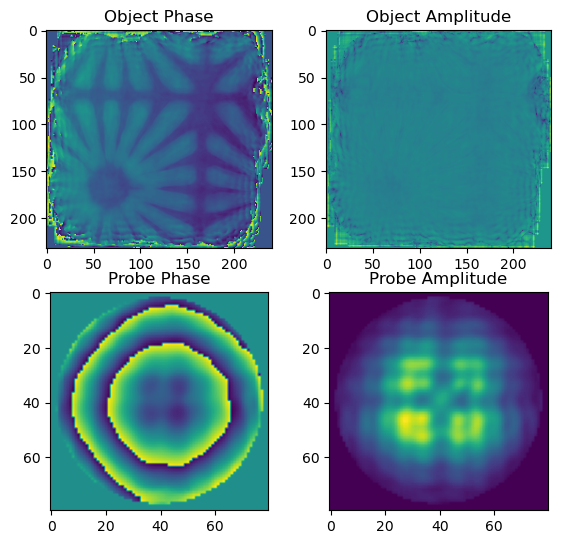

In [30]:
import numpy as np 
import h5py
import silx.io # the reconstructed data from Ptypy is stored in .ptyr file, needs to be read by silx.io 
import matplotlib.pyplot as plt


# single beam reconstruction imaging

f = silx.io.open("ReconData/1025_ML1000_original.ptyr")
Probe = f["/content/probe/SMFG00/data"]
Object = f["/content/obj/SMFG00/data"]

Prob_Amp = np.abs(Probe)
Prob_Phase = np.angle(Probe)
Obj_Amp = np.abs(Object)
Obj_Phase = np.angle(Object)

plt.show()
plt.subplots_adjust(left=0.0,bottom=0,top=1,right=0.8)

plt.subplot(2, 2, 1)
plt.imshow(Obj_Phase[0,:,:])
plt.title('Object Phase')

plt.subplot(2, 2, 2)
plt.imshow(np.log(Obj_Amp[0,:,:]))
plt.title('Object Amplitude')

plt.subplot(2, 2, 3)
plt.imshow(Prob_Phase[0,:,:])
plt.title('Probe Phase')

plt.subplot(2, 2, 4)
plt.imshow(Prob_Amp[0,:,:])
plt.title('Probe Amplitude')

#### Binning

Binning means merge a certain number of pixels to one pixel, and commonly used to lower the data volumn. From the reconstruction result with different binning number shows below can get that the smaller binning number leads to larger range of view. 

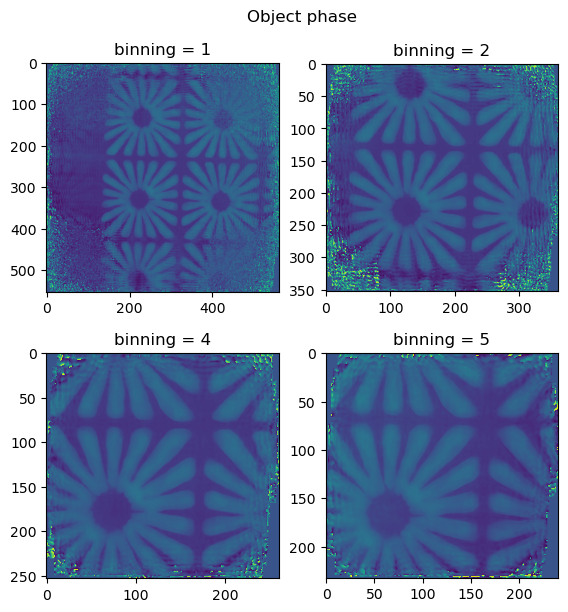

Text(0.4, 1.2, 'Probe amplitude')

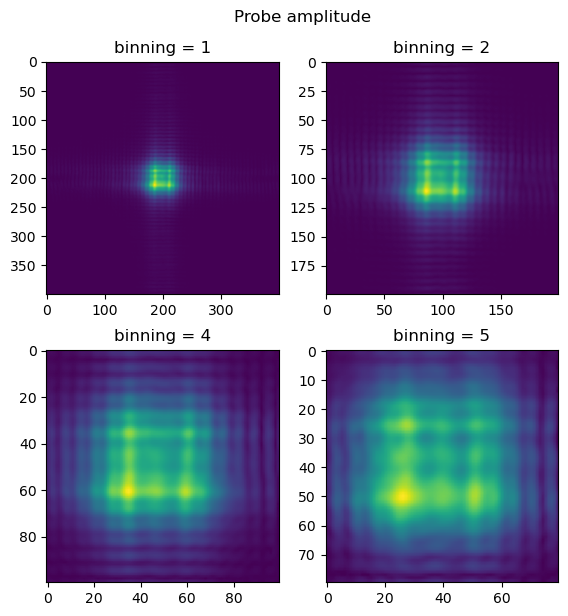

In [31]:
import numpy as np
import h5py
import silx.io
import matplotlib.pyplot as plt


# single beam reconstruction imaging

f1 = silx.io.open("ReconData/1025_binning=1.ptyr")
f2 = silx.io.open("ReconData/1025_binning=2.ptyr")
f3 = silx.io.open("ReconData/1025_binning=4.ptyr")
f4 = silx.io.open("ReconData/1025_binning=5.ptyr")

Probe1 = f1["/content/probe/Sscan00G00/data"]
Object1 = f1["/content/obj/Sscan00G00/data"]
Probe2 = f2["/content/probe/Sscan00G00/data"]
Object2 = f2["/content/obj/Sscan00G00/data"]
Probe3 = f3["/content/probe/Sscan00G00/data"]
Object3 = f3["/content/obj/Sscan00G00/data"]
Probe4 = f4["/content/probe/Sscan00G00/data"]
Object4 = f4["/content/obj/Sscan00G00/data"]

Obj_Phase1 = np.angle(Object1)
Obj_Phase2 = np.angle(Object2)
Obj_Phase3 = np.angle(Object3)
Obj_Phase4 = np.angle(Object4)

Prob_Amp1 = np.abs(Probe1)
Prob_Amp2 = np.abs(Probe2)
Prob_Amp3 = np.abs(Probe3)
Prob_Amp4 = np.abs(Probe4)

plt.show()
plt.subplots_adjust(left=0.0,bottom=0,top=1.1,right=0.8)

plt.subplot(2, 2, 1)
plt.imshow(Obj_Phase1[0,:,:]), plt.title('binning = 1')
plt.subplot(2, 2, 2)
plt.imshow(Obj_Phase2[0,:,:]), plt.title('binning = 2')
plt.subplot(2, 2, 3)
plt.imshow(Obj_Phase3[0,:,:]), plt.title('binning = 4')
plt.subplot(2, 2, 4)
plt.imshow(Obj_Phase4[0,:,:]), plt.title('binning = 5')
plt.suptitle('Object phase',x=0.4,y=1.2)

plt.show()
plt.subplots_adjust(left=0.0,bottom=0,top=1.1,right=0.8)

plt.subplot(2, 2, 1)
plt.imshow(Prob_Amp1[0,:,:]),plt.title('binning = 1')
plt.subplot(2, 2, 2)
plt.imshow(Prob_Amp2[0,:,:]), plt.title('binning = 2')
plt.subplot(2, 2, 3)
plt.imshow(Prob_Amp3[0,:,:]), plt.title('binning = 4')
plt.subplot(2, 2, 4)
plt.imshow(Prob_Amp4[0,:,:]), plt.title('binning = 5')
plt.suptitle('Probe amplitude',x=0.4,y=1.2)

#### Different algorithms

There are many algorithms for Ptychography reconstruction and the Ptypy package includes several popular algorithms. They are called engines in Ptypy, and different algorithms can be found here: https://ptycho.github.io/ptypy/rst/parameters.html#engine. 

Here, Difference Map (DM) [8], Maximum Likelihood (ML) [9] and ePIE [10] are used. Three conditions are: 1000 iterations of DM, 500 iterations DM and then 500 iterations ML, 1000 iterations of ePIE. 

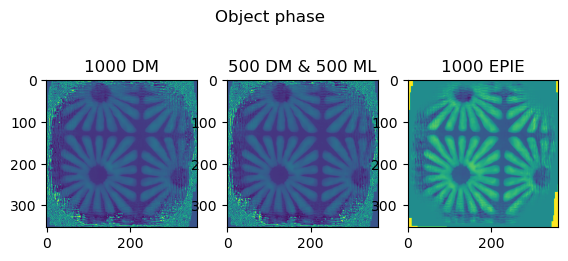

c:\Users\Runqing Yang\.conda\envs\py37\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log


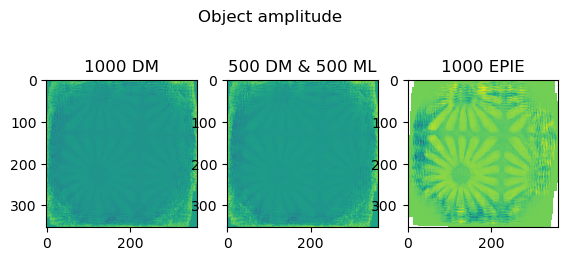

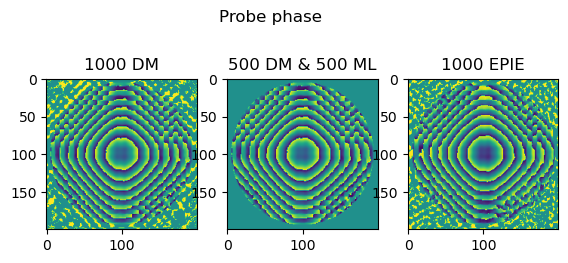

Text(0.35, 0.8, 'Probe amplitude')

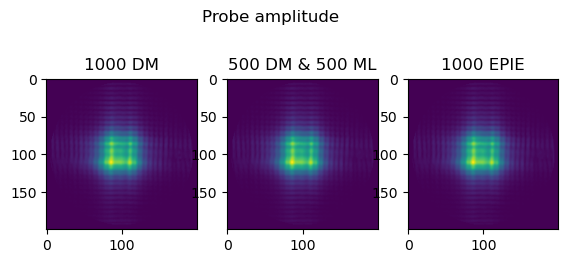

In [32]:
import numpy as np
import h5py
import silx.io
import matplotlib.pyplot as plt


# single beam reconstruction imaging

f1 = silx.io.open("ReconData/1025_DM1000.ptyr")
f2 = silx.io.open("ReconData/1025_DM500ML500.ptyr")
f3 = silx.io.open("ReconData/1025_EPIE1000.ptyr")


Probe1 = f1["/content/probe/SMFG00/data"]
Object1 = f1["/content/obj/SMFG00/data"]
Probe2 = f2["/content/probe/SMFG00/data"]
Object2 = f2["/content/obj/SMFG00/data"]
Probe3 = f3["/content/probe/SMFG00/data"]
Object3 = f3["/content/obj/SMFG00/data"]

Obj_Phase1 = np.angle(Object1)
Obj_Phase2 = np.angle(Object2)
Obj_Phase3 = np.angle(Object3)

Obj_Amp1 = np.abs(Object1)
Obj_Amp2 = np.abs(Object2)
Obj_Amp3 = np.abs(Object3)

Prob_Amp1 = np.abs(Probe1)
Prob_Amp2 = np.abs(Probe2)
Prob_Amp3 = np.abs(Probe3)

Prob_Phase1 = np.angle(Probe1)
Prob_Phase2 = np.angle(Probe2)
Prob_Phase3 = np.angle(Probe3)

# DM1000
plt.show()
plt.subplots_adjust(left=0.0,bottom=0,top=1,right=0.8)

plt.subplot(1, 3, 1)
plt.imshow(Obj_Phase1[0,:,:]), plt.title('1000 DM')
plt.subplot(1, 3, 2)
plt.imshow(Obj_Phase2[0,:,:]), plt.title('500 DM & 500 ML')
plt.subplot(1, 3, 3)
plt.imshow(Obj_Phase3[0,:,:]), plt.title('1000 EPIE')
plt.suptitle('Object phase',x=0.35,y=0.8)


plt.show()
plt.subplots_adjust(left=0.0,bottom=0,top=1,right=0.8)

plt.subplot(1, 3, 1)
plt.imshow(np.log(Obj_Amp1[0,:,:])), plt.title('1000 DM')
plt.subplot(1, 3, 2)
plt.imshow(np.log(Obj_Amp2[0,:,:])), plt.title('500 DM & 500 ML')
plt.subplot(1, 3, 3)
plt.imshow(np.log(Obj_Amp3[0,:,:])), plt.title('1000 EPIE')
plt.suptitle('Object amplitude',x=0.35,y=0.8)

plt.show()
plt.subplots_adjust(left=0.0,bottom=0,top=1,right=0.8)

plt.subplot(1, 3, 1)
plt.imshow(Prob_Phase1[0,:,:]), plt.title('1000 DM')
plt.subplot(1, 3, 2)
plt.imshow(Prob_Phase2[0,:,:]), plt.title('500 DM & 500 ML')
plt.subplot(1, 3, 3)
plt.imshow(Prob_Phase3[0,:,:]), plt.title('1000 EPIE')
plt.suptitle('Probe phase',x=0.35,y=0.8)

plt.show()
plt.subplots_adjust(left=0.0,bottom=0,top=1,right=0.8)

plt.subplot(1, 3, 1)
plt.imshow(Prob_Amp1[0,:,:]), plt.title('1000 DM')
plt.subplot(1, 3, 2)
plt.imshow(Prob_Amp2[0,:,:]), plt.title('500 DM & 500 ML')
plt.subplot(1, 3, 3)
plt.imshow(Prob_Amp2[0,:,:]), plt.title('1000 EPIE')
plt.suptitle('Probe amplitude',x=0.35,y=0.8)

## Reference

[1] Millane, Rick P. "Phase retrieval in crystallography and optics." JOSA A 7.3 (1990): 394-411.

[2] Miao, Jianwei, et al. "Extending the methodology of X-ray crystallography to allow imaging of micrometre-sized non-crystalline specimens." Nature 400.6742 (1999): 342-344.

[3] Fienup, James R. "Reconstruction of an object from the modulus of its Fourier transform." Optics letters 3.1 (1978): 27-29.

[4] Gerchberg, Ralph W. "A practical algorithm for the determination of plane from image and diffraction pictures." Optik 35.2 (1972): 237-246.

[5] Miao, Jianwei, J. Kirz, and D. Sayre. "The oversampling phasing method." Acta Crystallographica Section D: Biological Crystallography 56.10 (2000): 1312-1315.

[6] Pfeiffer, Franz. "X-ray ptychography." Nature Photonics 12.1 (2018): 9-17.

[7] Enders, B., and P. Thibault. "A computational framework for ptychographic reconstructions." Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences 472.2196 (2016): 20160640.

[8] Kewish, Cameron M., et al. "Ptychographic characterization of the wavefield in the focus of reflective hard X-ray optics." Ultramicroscopy 110.4 (2010): 325-329.

[9] Thibault, Pierre, and Manuel Guizar-Sicairos. "Maximum-likelihood refinement for coherent diffractive imaging." New Journal of Physics 14.6 (2012): 063004.

[10] Maiden, Andrew M., and John M. Rodenburg. "An improved ptychographical phase retrieval algorithm for diffractive imaging." Ultramicroscopy 109.10 (2009): 1256-1262.
